## Answers in the wind.
## Project: Multi-year wind trends in the North Sea

This notebook uses meteorological observations from NOAA (US National Oceanic and Atmospheric Administration) to explore multi-year wind trends in the North Sea. The topic is of importance to energy companies who have offshore wind parks and would like to better plan their future production.

This project will use the CRISP-DM methodology and will focus on the first 5 steps of the methodology:
1. Business understanding.
2. Data understanding.
3. Data preparation.
4. Modeling
5. Evaluation
6. Deployment

### Business understanding
Offshore wind farms are constructed in the sea and harvest wind energy to generate electricity. Currently the biggest cluster of offshore wind farms is in the German Northern Sea. As **wind** is the key factor influencing production, understanding of long-term wind trends will help forecasting and planning of offshore electricity production for the next years. To contribute to this cause, the current project will focus on **exploring multi-year wind trends in the North Sea.**

The questions to be answered are:
1. Which meteorological station should be used to understand long-term wind trends in the German North Sea?
2. Is the wind in the North Sea similar to what it was decades ago?
3. What is the monthly (i.e. intra-year) seasonality of wind?
4. What multi-year wind trends do we observe?

### Data understanding
The project will use the public data from the Integrated Global Radiosonde Archive (IGRA) Version 2. This archive consists of quality-controlled radiosonde observations of temperature, humidity, and wind at stations across all continents. Record length and availability of variables varies among stations and over time. In addition monthly means at mandatory pressure levels is included as a supplementary product.
To answer the business question *1. Which meteorological station should be used to understand long-term wind trends in the German North Sea?* we first need to understand which meteorological stations are availble in the german Northern Sea, and which station has the longest records.

In [1]:
%matplotlib inline
import os
import pandas as pd
import folium
import numpy as np
from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen
from statsmodels.tsa import stattools
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error
from plotnine import ggplot, aes, geom_tile, ggtitle, geom_line, \
    stat_smooth, geom_density, scale_color_manual, geom_point, \
    scale_color_manual, geom_col, scale_x_continuous, ylab,\
    scale_linetype_manual, scale_size_manual

In [2]:
inpfpath = os.path.join(os.getcwd(),"Inputs", "igra2-station-list.txt")

# Read data as a list; each line is one string
# 1st line:
# AEM00041217  24.4333   54.6500   16.0    ABU DHABI INTERNATIONAL AIRPOR 1983 2019  36595
with open(inpfpath, 'r') as f:
    lines = [line for line in f]

# Transform the one-line list to a data frame with latitude and longitude
col_split_tuple = (0, 11, 20, 30, 37, 71, 76, 81, 88)
col_names = ("station_ID", "latitude", "longitude", "height", "name", \
           "record_start", "record_end", "records_number")

data = pd.DataFrame()
for i in range(0, len(lines)):
    line_to_cols = [lines[i][col_split_tuple[j]:col_split_tuple[j+1]] \
     for j in range(0, len(col_split_tuple)-1)]
    data = data.append(pd.Series(line_to_cols), ignore_index=True)
data.columns = col_names
data = data.apply(lambda x: x.str.strip())
num_col_names = ["latitude", "longitude", "height", "record_start",\
                 "record_end", "records_number"]
for num_col in num_col_names:
    data[num_col] = pd.to_numeric(data[num_col], errors='coerce')

# Some stations don't have a stable longitude as they are  oceanographic research ships
# Remove these stations as they are not relevant for the project
data = data[data.longitude > -998.888800]

# Create a folim map instance and plot our stations in the German Northern Sea
# Circle size relates to number of records (i.e. number of historical data)
# Highlight SCHLESWIG station
m = folium.Map(location=[54, 5], tiles = 'cartodbpositron', \
               zoom_start=5, control_scale=True)
scaling_factor = 1
selected_stations_index =\
    data[(data["latitude"] > 30) & (data["latitude"] < 60)\
    & (data["longitude"] > -10)& (data["longitude"] < 30)].index
for i in selected_stations_index:
    if data.iloc[i]["name"] == "SCHLESWIG":
        folium.Circle(
            location = [data.iloc[i]["latitude"], data.iloc[i]["longitude"]],
            radius = int(round(data.iloc[i]["records_number"] * scaling_factor)),
            popup = data.iloc[i]["name"],
            color = '#008000',
            fill = True,
            fill_color = '#008000'
        ).add_to(m)
    else:
        folium.Circle(
            location = [data.iloc[i]["latitude"], data.iloc[i]["longitude"]],
            radius = int(round(data.iloc[i]["records_number"] * scaling_factor)),
            popup = data.iloc[i]["name"],
            color = '#3186cc',
            fill = True,
            fill_color = '#3186cc'
        ).add_to(m)

m

### *Question 1. Which meteorological station should be used to understand long-term wind trends in the German North Sea?*
The german Northern Sea station with the logest record is **SCHLESWIG**. It will be used for further analyses.

In [3]:
st_ID_SCH = data.loc[data["name"] == "SCHLESWIG", "station_ID"].values[0]
data[data["name"] == "SCHLESWIG"]

,station_ID,latitude,longitude,height,name,record_start,record_end,records_number
823,GMM00010035,54.5333,9.55,47.0,SCHLESWIG,1954,2019,68453


To answer the business question *2. Is the wind in the North Sea similar to what it was decades ago?* we need to get and explore the monthly wind data for SCHLESWIG station.

In [4]:
#Fetch the files from the server and unzip in Input folder
url_address = "https://www1.ncdc.noaa.gov/pub/data/igra/monthly/monthly-por/"
zip_list = ["uwnd_00z-mly.txt.zip", "uwnd_12z-mly.txt.zip",\
            "vwnd_00z-mly.txt.zip", "vwnd_12z-mly.txt.zip"]
zip_list_files = [url_address+file for file in zip_list]
inpfpath = os.path.join(os.getcwd(),"Inputs")

for archive_url in zip_list_files:
    resp = urlopen(archive_url)
    zip_ref = ZipFile(BytesIO(resp.read()))
    zip_ref.extractall(inpfpath)
    zip_ref.close()

# Input files consist of monthly wind averages along the "x" and "y" axes
# taken twice a day (at 00:00 and 12:00) at various pressure levels (i.e. heights)
inp_files = {
        "uwnd_00z-mly.txt" : ["wind-EW", 0], #Zonal wind component m/s x 10
        "uwnd_12z-mly.txt" : ["wind-EW", 12], #Zonal wind component m/s x 10
        "vwnd_00z-mly.txt" : ["wind-NS", 0], #Meridional wind component m/s x 10
        "vwnd_12z-mly.txt" : ["wind-NS", 12] #Meridional wind component m/s x 10
    }
# Line structure in files:
#ID            1- 11  Character
#YEAR         13- 16  Integer
#MONTH        18- 19  Integer
#LEVEL        21- 24  Integer (pressure level in hPa)
#VALUE        26- 31  Integer (wind speed in m/s)
#NUM          33- 34  Integer (number of values used to calculate the mean)
#Example 1st line:
#ACM00078861 1947  1 9999     10 13

# The desired height for wind analysis is ~110m (i.e. the actual height of
# offshore wind farms), or pressure level of 1000hPa
pressure_level = ["1000"]
# Other pressure levels (not explored) include: 
# 9999 = surface level
# 925 = ~760m height

# data will be read in 2 data frames (for 00:00 and 12:00) and concatenated at the end
data_0 = pd.DataFrame()
data_12 = pd.DataFrame()

for f_name in list(inp_files.keys()):
    inpfpath = os.path.join(os.getcwd(),"Inputs", f_name)
    
    # Read only lines related to SCHLESWIG
    lines = []
    with open(inpfpath, 'r') as f:
        for line in f:
            if (line[0:11] == st_ID_SCH) & (line[20:24] in pressure_level):
                lines.append(line)

    # Transform the one-line list to a data frame
    col_split_tuple = (11, 16, 19, 24, 31)
    col_names = ("year", "month", "pressure", inp_files[f_name][0])
    
    temp_data = pd.DataFrame()
    
    for i in range(0, len(lines)):
        line_to_cols = [lines[i][col_split_tuple[j]:col_split_tuple[j+1]] \
                        for j in range(0, len(col_split_tuple)-1)]
        temp_data = temp_data.append(pd.Series(line_to_cols), ignore_index=True)
    
    temp_data.columns = col_names
#    temp_data.rename(columns={"geo_height_1000":"hour"}, inplace=True)
    temp_data["hour"] = inp_files[f_name][1]
    #temp_data = temp_data.apply(lambda x: x.str.strip())
    num_col_names = ["year", "month", "pressure", inp_files[f_name][0]]
    for num_col in num_col_names:
        temp_data[num_col] = pd.to_numeric(temp_data[num_col], errors='coerce')

    if inp_files[f_name][1] == 0:
        if data_0.shape[0] == 0:
            data_0 = temp_data
        else:
            data_0 = pd.merge(data_0, temp_data, on=["year", "month", "hour", "pressure"],\
                                                 how="outer")
    else:
        if data_12.shape[0] == 0:
            data_12 = temp_data
        else:
            data_12 = pd.merge(data_12, temp_data, on=["year", "month", "hour", "pressure"],\
                                                 how="outer")

data = pd.concat([data_0, data_12]).reset_index(drop = True)

# Adjust values to proper scale in m/s to 1 decimal point
data[["wind-EW", "wind-NS"]] = data[["wind-EW", "wind-NS"]]/10

# Calculate total wind speed from x and y components of wind
data["wind"] = np.sqrt(np.square(data["wind-EW"]) + np.square(data["wind-NS"]))
data.drop(columns = ["pressure", "wind-EW", "wind-NS"], axis = 1, inplace = True)

print(data.shape)
data.head()

(1521, 4)


,year,month,hour,wind
0,1954,10,0,4.201190
1,1954,11,0,2.236068
2,1954,12,0,6.887670
3,1955,1,0,2.360085
4,1955,2,0,4.614109


### Data preparation
Next, we need to deal with missing values. Missing values will be imputed - for both 00:00 and 12:00 - as an average of the month (for each relevant hour) across the data set. The 00:00 monthly data ends in Mar-2018, while the 12:00 monthly data ends in Aug-2019 (i.e. 1 year and 4 months later). As we will use the last part of the data for testing purposes, imputing with averages would not be accurate here. We will restrict our data until Mar-2018.

After imputation, the 00:00 and 12:00 will be averaged to arrive at one final monthly value for the wind speed.

Another alternative to deal with missing data - not followed here - would be to fill the missing values from provided wind averages at different pressure level (i.e. heights) than the chosen one for analysis.

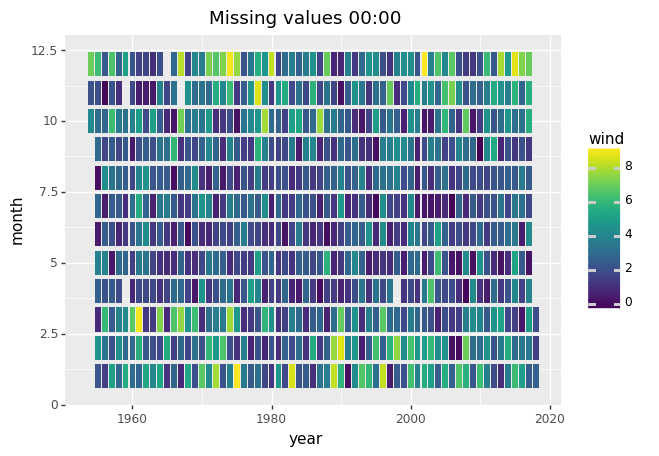

<ggplot: (-9223371934766397545)>

In [5]:
data_plot = data.loc[data["hour"] == 0,\
                     ["year", "month", "wind"]].copy()
ggplot(data_plot, aes(x="year", y="month", fill="wind")) +\
    geom_tile(aes(width=.85, height=.85))+\
    ggtitle("Missing values 00:00")

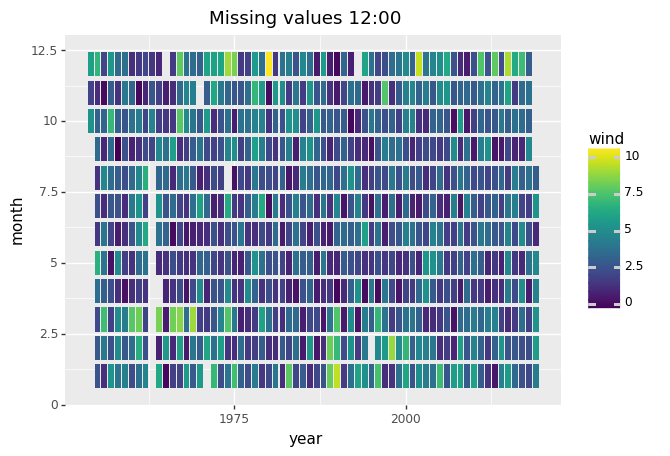

<ggplot: (102083256889)>

In [6]:
data_plot = data.loc[data["hour"] == 12,\
                     ["year", "month", "wind"]].copy()
ggplot(data_plot, aes(x="year", y="month", fill="wind")) +\
    geom_tile(aes(width=.85, height=.85))+\
    ggtitle("Missing values 12:00")

In [7]:
def fill_w_averages (df, dti, fill_h):
    """Fills the missing values with the average monthly wind speed

    Parameters
    ----------
    df : DataFrame
        The data frame with all wind relevant data
    dti : DatetimeIndex
        The time period for which the wind data should be arranged/filled
    fill_h : integer
        The hour for which the missing values should be filled (i.e. 00:00 or 12:00)

    Returns
    -------
    DataFrame
        The filled DataFrame for the 
    """
    df = df[df["hour"] == fill_h]
    # create index for return df
    data_arranged = pd.DataFrame(dti)
    data_arranged.rename(columns={0:'date'}, inplace=True)
    data_arranged["year"] = data_arranged["date"].apply(lambda x: x.year)
    data_arranged["month"] = data_arranged["date"].apply(lambda x: x.month)
    data_arranged = pd.merge(data_arranged, \
                              df[["year", "month", "wind"]],\
                              on = ["year", "month"], how = "left")
    
    # calculate average for missing months
    missing_val = pd.DataFrame(np.where(data_arranged['wind'].isnull())[0], \
                               columns = ["ID"])
    missing_val["month"] = data_arranged.loc[missing_val["ID"],"month"].values
    av_per_month = data_arranged.groupby("month", as_index = False)["wind"].mean()
    missing_val = pd.merge(missing_val, av_per_month, how = "left", on = "month")
    
    # fill missing months in the return df
    data_arranged.loc[missing_val["ID"],"wind"] = missing_val["wind"].to_numpy()

    return data_arranged

fill_period = pd.date_range('1954-10-01', periods=762, freq="M")
print("End month: "+str(fill_period[len(fill_period)-1]))

data_0 = fill_w_averages (data, fill_period, 0)
data_12 = fill_w_averages (data, fill_period, 12)

data = pd.concat([data_0, data_12]).reset_index(drop = True)
data = data.groupby(["date", "year", "month"], as_index = False).mean()

print(data.shape)
data.head()

End month: 2018-03-31 00:00:00
(762, 4)


,date,year,month,wind
0,1954-10-31,1954,10,4.725476
1,1954-11-30,1954,11,2.129221
2,1954-12-31,1954,12,6.340816
3,1955-01-31,1955,1,2.525405
4,1955-02-28,1955,2,3.722152


### *Question 2. Is the wind in the North Sea similar to what it was decades ago?*
Yes, there doesn't appear to be any systematic change in wind patterns across the analyzed period.

C:\Progs\miniconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


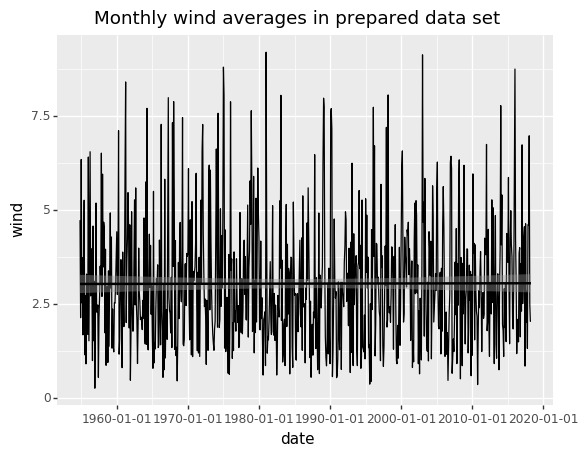

<ggplot: (102089767628)>

In [8]:
# Line plot of monthly wind averages in m/s

data_plot = data.copy()
ggplot(data_plot, aes("date", "wind")) + \
    geom_line() + \
    stat_smooth(method="lm")+\
    ggtitle("Monthly wind averages in prepared data set")

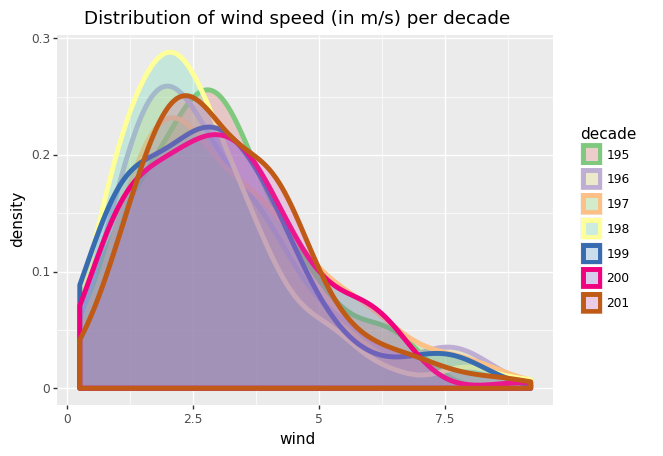

<ggplot: (-9223371934764772506)>

In [9]:
# Distribution of wind speed (in m/s) per decade

color = ('#7fc97f','#beaed4','#fdc086','#ffff99','#386cb0','#f0027f','#bf5b17')
data_plot = data.copy()
data_plot["decade"] = np.floor_divide(data_plot["year"],10).astype(str)
ggplot(data_plot, aes(x="wind", group="decade", fill="decade", color="decade")) +\
    geom_density(size=2, alpha=0.25) +\
    scale_color_manual(values = color)+\
    ggtitle("Distribution of wind speed (in m/s) per decade")

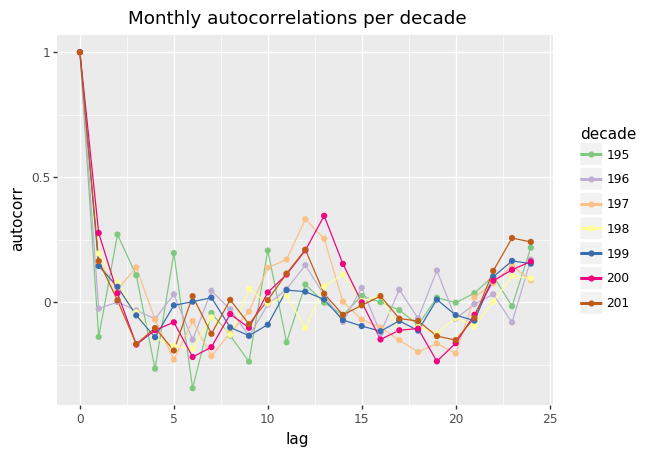

<ggplot: (102090493704)>

In [10]:
# Monthly autocorrelations per decade

data_plot = data.copy()
data_plot["decade"] = np.floor_divide(data_plot["year"],10).astype(str)
decades = tuple(data_plot["decade"].unique())
data_autocorr = pd.DataFrame()
for dec in decades:
    temp_data = pd.DataFrame()
    autocorr = stattools.acf(data_plot.loc[data_plot["decade"] == dec, "wind"],\
                             nlags=24)
    temp_data["autocorr"]  = autocorr
    temp_data["lag"]  = temp_data.index
    temp_data["decade"]  = dec
    data_autocorr = pd.concat([data_autocorr, temp_data])

ggplot(data_autocorr, aes("lag", "autocorr", color="decade")) + \
    geom_line() +\
    geom_point() +\
    scale_color_manual(values = color)+\
    ggtitle("Monthly autocorrelations per decade")

### Modelling
The next question focuses on intra-year (i.e. monthly) seasonality. We will answer it by fitting a regression model with input equal to monthly categorical variable, and average monthly wind speed (in m/s) as output.

For the next part of the project data will be split into training period (Oct-1954 until Dec-1999) and testing period (Jan-200 until Mar-2018). Testing period thus comprises 29% of observations. (As our input data is a time series, a random partition is not advised, as it does not mimic the temporal uncertainty where we use the past to forecast the future and it creates time series with "holes", whereas many forecasting methods cannot handle missing values.)

In [11]:
test_indices = data.loc[data["year"] >= 2000].index
training_indices = data.loc[(data["date"] <= "1999-12-31 00:00:00")].index
data_training = data.loc[training_indices,].copy()

# Create month variables
cat_encoder = OneHotEncoder(sparse=False, drop = "first", categories='auto')
X = cat_encoder.fit_transform(data_training["month"].values.reshape(-1, 1))
y = data_training["wind"]

# Model seasonality (additive version)
lin_reg = LinearRegression(normalize=True)
lin_reg.fit(X, y)

print("Seasonality (training) model results")
print("Mean absolute error: "+str(mean_absolute_error(y, lin_reg.predict(X))))
print("R2: "+str(r2_score(y, lin_reg.predict(X))))

Seasonality (training) model results
Mean absolute error: 1.270422695249101
R2: 0.12994673915380617


### *Question 3: What is the intra-year seasonality of wind?*
Winter is the most windy season, with Dec-Mar being almost twice as windy as Apr-Jun.
For the follow-up analyses, the data will be "de-seasonalized" using the computed monthly seasonal coefficients.

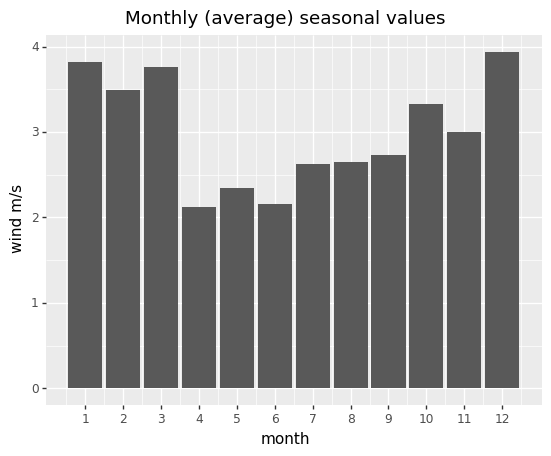

<ggplot: (-9223371934766399193)>

In [12]:
season_factors = pd.DataFrame(list(zip(range(cat_encoder.categories_[0].size-1), lin_reg.coef_)),\
            columns=["month", "coefficient"])
season_factors["month"] = season_factors.index+2
season_factors = pd.concat([season_factors,\
                           pd.DataFrame(dict(month=[1], coefficient=[0]))],\
                            sort=True, ignore_index = True)
season_factors["coefficient_avg"] = season_factors["coefficient"] + lin_reg.intercept_

ggplot(season_factors, aes("month", "coefficient_avg")) +\
  geom_col() +\
  scale_x_continuous(breaks=list(range(1,13))) +\
  ylab("wind m/s")+\
  ggtitle("Monthly (average) seasonal values")

In [13]:
# create (monthly) seasonally adjusted data
data = pd.merge(data,season_factors[["month", "coefficient"]], how = "left", on = "month")
data["wind_sa"] = data["wind"] - data["coefficient"]
# scale from "January seasonal adjustmnet" to average seasonal adjustment
data["wind_sa"] = data["wind_sa"]*(data["wind"].mean()/data["wind_sa"].mean())
data.drop(columns = "coefficient", axis = 1, inplace = True)
data = data.reset_index()
data.head()

,index,date,year,month,wind,wind_sa
0,0,1954-10-31,1954,10,4.725476,4.112587
1,1,1954-11-30,1954,11,2.129221,2.327912
2,2,1954-12-31,1954,12,6.340816,4.903242
3,3,1955-01-31,1955,1,2.525405,1.987722
4,4,1955-02-28,1955,2,3.722152,3.192523


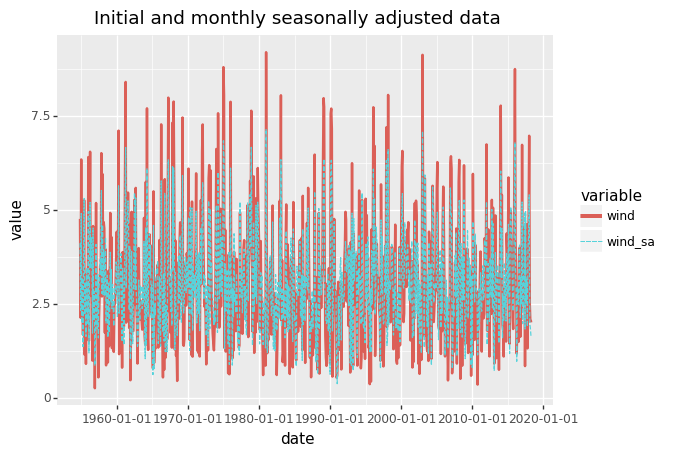

<ggplot: (102088375823)>

In [14]:
data_plot = data.copy()
data_plot.drop(columns = ["year", "month", "index"], axis = 1, inplace = True)
data_plot = pd.melt(data_plot, id_vars="date", var_name="variable", value_name="value")
data_plot.head()
ggplot(data_plot, aes("date", "value", color='variable')) + \
    geom_line(aes(linetype='variable', size='variable'))+\
    scale_linetype_manual(["-", "--"])+\
    scale_size_manual((1, 0.5))+\
    ggtitle("Initial and monthly seasonally adjusted data")

### Modelling and Evaluation
To explore multi-year wind trends, we will use a periodic regression model which models a sinusoidal pattern on time-series data. (See acknowledgements for more details).
\begin{align*}
y_t = \beta_0 + \beta_1t + \beta_2t^2 + \beta_3sin\left(\frac{2\pi t}{periodicity}\right) + \beta_4cos\left(\frac{2\pi t}{periodicity}\right) + \epsilon
\end{align*}
with the yearly periodicity of monthly data being 12

### *Question 4: What multi-year wind trends do we observe?*
None. The testing period has negative R2 coefficients for all tried frequencies, implying that a naive forecats (i.e. a constant number) is better at forecasting the multi-year seasonally adjusted wind than a linear model with sinuoidal pattern.

In [15]:
def test_r2s (df_training, df_test, frequency_list):
    """Function tests a periodic regression according to the specified frequency list
    and returns a list of corresponding R2 coefficients

    Parameters
    ----------
    df_training : DataFrame
        The training data frame for the regression
    df_test : DataFrame
        The test data frame against which the regression will be evaluated
    frequency_list : float
        The yearly frequency of the sinusoidal pattern to be tested

    Returns
    -------
    List
        R2 coefficients on test data frame corresponding to the frequency list
    List
        Coefficient list for the regression with the maximum R2
    """

    lin_reg = LinearRegression(normalize=True)
    list_r2 = []
    max_r2 = -np.Inf
    list_coefs = []
    for frequency in frequency_list:
        X_train = pd.DataFrame(df_training["index"])
        X_train["index2"] = np.square(X_train["index"])
        X_train["sin"] = np.sin(X_train["index"]*2*np.pi/(frequency*12))
        X_train["cos"] = np.cos(X_train["index"]*2*np.pi/(frequency*12))
#        X_train.drop(columns = "index", axis = 1, inplace = True)
        y_train = df_training["wind_sa"].copy()

        X_test = pd.DataFrame(df_test["index"])
        X_test["index2"] = np.square(X_test["index"])
        X_test["sin"] = np.sin(X_test["index"]*2*np.pi/(frequency*12))
        X_test["cos"] = np.cos(X_test["index"]*2*np.pi/(frequency*12))
#        X_test.drop(columns = "index", axis = 1, inplace = True)
        y_test = df_test["wind_sa"].copy()

        lin_reg.fit(X_train, y_train)
        r2 = r2_score(y_test, lin_reg.predict(X_test))
        list_r2.append(r2)
        if r2 > max_r2:
            max_r2 = r2
            list_coefs = list(lin_reg.coef_)
            list_coefs.insert(0, lin_reg.intercept_)

    return list_r2, list_coefs

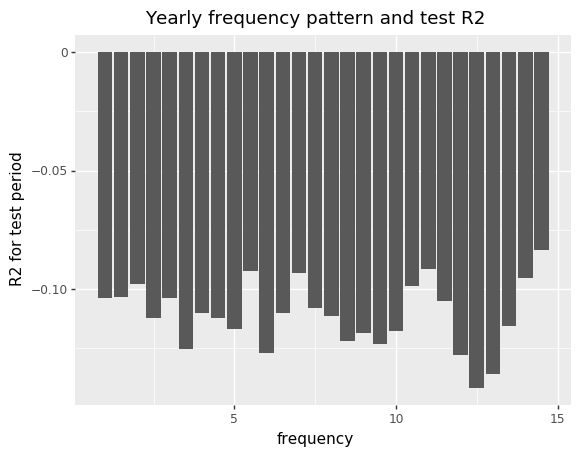

<ggplot: (-9223371934764198547)>

In [16]:
data_training = data.loc[training_indices,].copy()
data_testing = data.loc[test_indices,].copy()
tested_frequencies = list(np.arange(1,15,0.5))

r2_list, reg_coefs = test_r2s(data_training, data_testing, tested_frequencies)

data_plot = pd.DataFrame(list(zip(tested_frequencies, r2_list)), \
                         columns = ["frequency", "r2_test"])

ggplot(data_plot, aes("frequency", "r2_test")) +\
  geom_col()+\
  ylab("R2 for test period")+\
  ggtitle("Yearly frequency pattern and test R2")

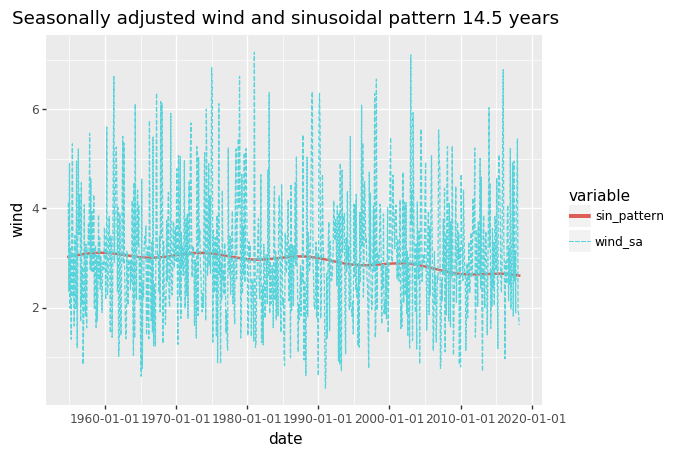

<ggplot: (-9223371934764151222)>

In [17]:
data_plot = data.copy()
data_plot = data_plot[["date", "index", "wind_sa"]]
frequency = tested_frequencies[r2_list.index(max(r2_list))]
data_plot["sin_pattern"] =\
    reg_coefs[0]+\
    data_plot["index"]*reg_coefs[1]+\
    np.square(data_plot["index"])*reg_coefs[2]+\
    np.sin(data_plot["index"]*2*np.pi/(frequency*12))*reg_coefs[3] +\
    np.cos(data_plot["index"]*2*np.pi/(frequency*12))*reg_coefs[4]
data_plot.drop(columns = "index", axis = 1, inplace = True)
data_plot = pd.melt(data_plot, id_vars="date", var_name="variable", value_name="wind")

ggplot(data_plot, aes("date", "wind", color='variable')) + \
    geom_line(aes(linetype='variable', size='variable'))+\
    scale_linetype_manual(["-", "--"])+\
    scale_size_manual((1, 0.5))+\
    ggtitle("Seasonally adjusted wind and sinusoidal pattern " +\
            str(frequency) + " years")

### Acknowledgements
*Dataset:* Durre, Imke; Xungang, Yin; Vose, Russell S.; Applequist, Scott; Arnfield, Jeff. (2016) Integrated Global Radiosonde Archive (IGRA), Version 2. Monthly means for the full period of record for SCHLESWIG station. NOAA National Centers for Environmental Information. DOI:10.7289/V5X63K0Q Accessed 15.06.2019.

*Periodic regression model* as implemented in https://www.cdc.gov/mmwr/preview/mmwrhtml/mm5914a3.htm